In [1]:
import torch
import matplotlib.pyplot as plt
from torch.ao.nn.qat import Linear
%matplotlib inline
import torch.nn.functional as F

In [2]:
words = open('../names.txt','r').read().splitlines()
words[:3]

['emma', 'olivia', 'ava']

In [3]:
# building the vocab of words and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# building the dataset
block_size = 3
def build_datatset(words):
    X,y = [] , []
    for w in words:
        context = [0] * block_size
        for ch in w +'.':
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    y = torch.tensor(y)
    return X,y


import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,ytr = build_datatset(words[:n1])
Xval,yval = build_datatset(words[n1:n2])
Xte,yte = build_datatset(words[n2:])



In [5]:
Xtr

tensor([[ 0,  0,  0],
        [ 0,  0, 25],
        [ 0, 25, 21],
        ...,
        [15, 12,  4],
        [12,  4,  1],
        [ 4,  1, 14]])

In [6]:
ytr

tensor([25, 21,  8,  ...,  1, 14,  0])

In [8]:
n_embed = 10
n_hidden = 200
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embed),generator=g)
w1 = torch.randn((n_embed*block_size,n_hidden),generator=g) * (5/3) / ((n_embed* block_size)**0.5)                 #0.2
b1 = torch.randn(n_hidden,generator=g) *0.01
w2 = torch.randn((n_hidden,vocab_size),generator=g) * 0.1
b2 = torch.randn(vocab_size,generator=g) * 0


# -------------------- BatchNorm params ------------------------------
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

#----------------------------------------------------------------------

params = [C,w1,b1,w2,b2,bngain,bnbias]
print(sum(p.nelement() for p in params))
for p in params:
    p.requires_grad = True

12297


In [9]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # construction of mini batch
    idx = torch.randint(0,Xtr.shape[0],(batch_size,))
    Xb,Yb = Xtr[idx],ytr[idx] # batch X , Y

    # forward pass
    emb = C[Xb]  # embed the chars ibn to vectors
    embcat = emb.view(emb.shape[0],-1)

    # ------ Linear Layer --------------------------------------------------------
    hpract = embcat @ w1 + b1 # hidden layer pre activation


    # ------- BatchNorm  layer -------------------------------------------------------
    bnmeani =  hpract.mean(0,keepdim=True)
    bnstdi = hpract.std(0,keepdim=True)
    hpract = bngain * (hpract- bnmeani ) / bnstdi + bnbias # batch normalization

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi


    # -------------------------------------------------------------

    h = torch.tanh(hpract) # non linearity
    logits = h @ w2 + b2 # output layer
    loss = F.cross_entropy(logits,Yb) # loss function

    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01 # learning rate decay
    for p in params:
        p.data += - lr * p.grad

    # track stats
    if i % 10000 ==0 :
        print(f"step {i} loss {loss.item():.4f}")

    lossi.append(loss.log10().item())



step 0 loss 3.7475
step 10000 loss 2.5449
step 20000 loss 1.9778
step 30000 loss 2.0480
step 40000 loss 2.0239
step 50000 loss 2.2029
step 60000 loss 2.2271
step 70000 loss 2.3011
step 80000 loss 1.8696
step 90000 loss 2.3685
step 100000 loss 1.9344
step 110000 loss 2.0298
step 120000 loss 2.5868
step 130000 loss 2.0814
step 140000 loss 2.5927
step 150000 loss 2.1531
step 160000 loss 1.7610
step 170000 loss 2.1715
step 180000 loss 2.1474
step 190000 loss 1.8511


tensor(0.0105) tensor(1.0112)
tensor(0.0032) tensor(1.0007)


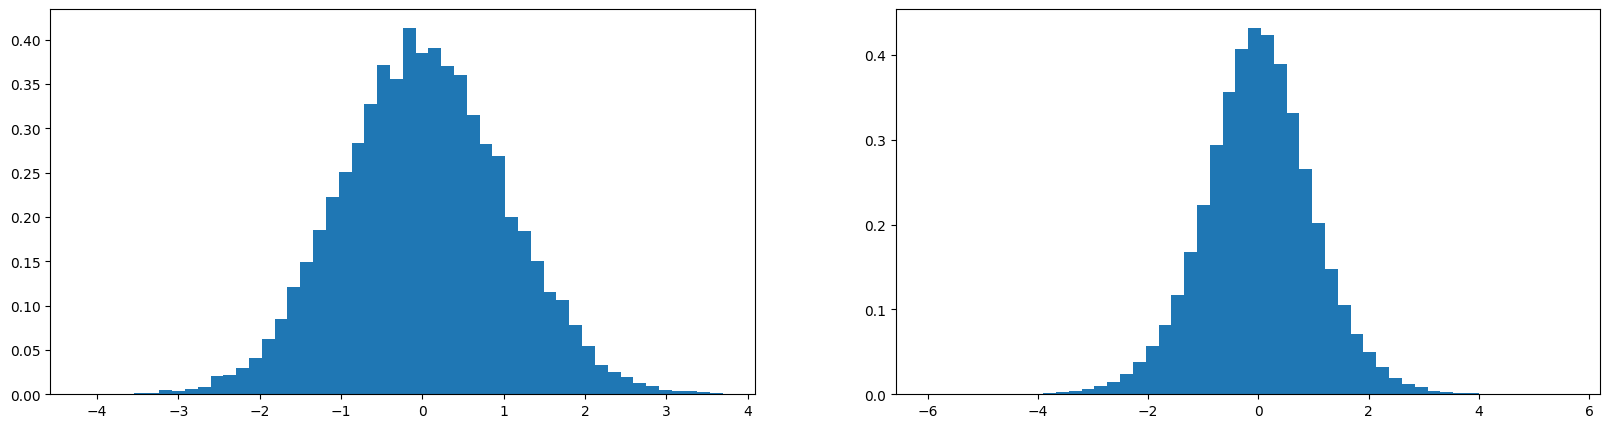

In [10]:
# the need of batch normalization explained
x = torch.randn(1000,10)
w = torch.randn(10,200) / 10**0.5
y = x @ w
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True);


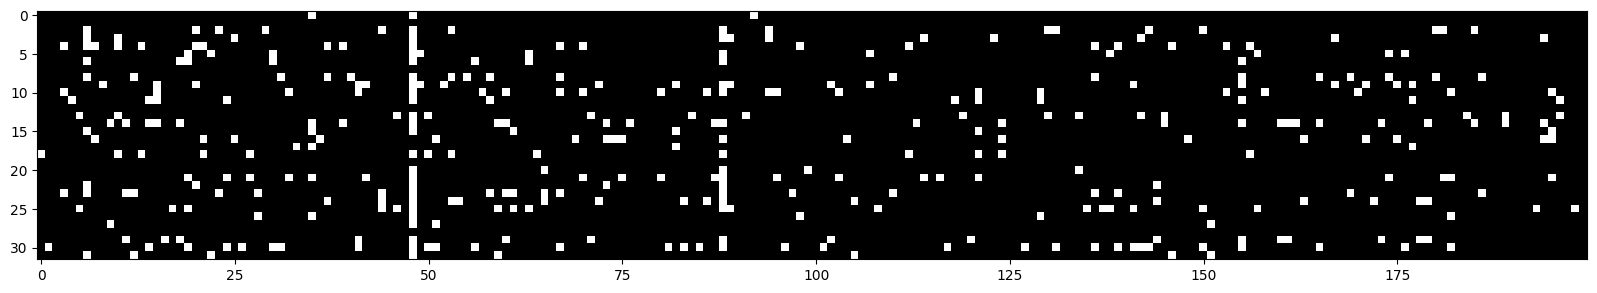

In [11]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest') # white is flat region and black is steep region of tanh function so black is good white is bad and if a column is completely white then basically that neuron is a dead neuron

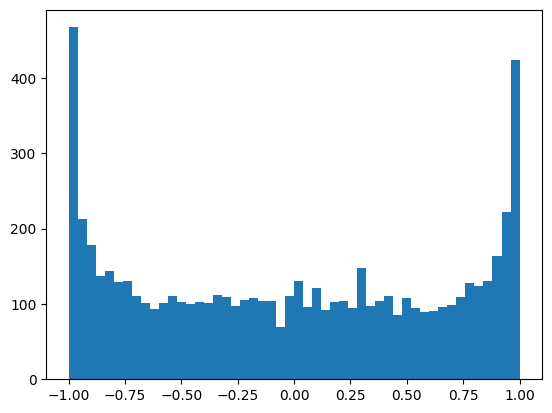

In [12]:
plt.hist(h.view(-1).tolist(),50);

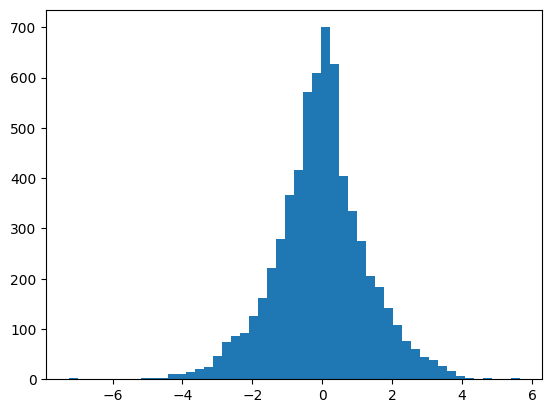

In [13]:
plt.hist(hpract.view(-1).tolist(),50);

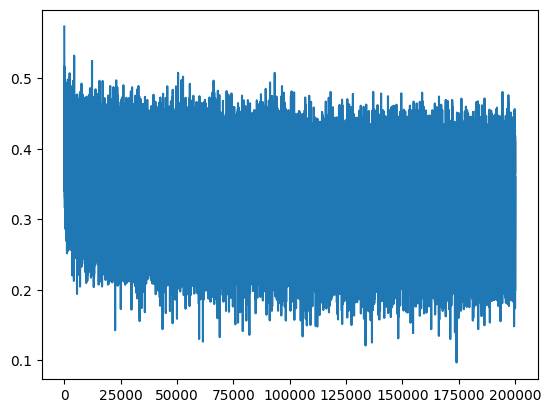

In [14]:
plt.plot(lossi)

In [15]:
# calibrate the batch norm at the end of training
with torch.no_grad():
    # pass the entire training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0],-1)
    hpract = embcat @ w1 + b1
    # measure mean and std over the entire training set
    bnmean = hpract.mean(0,keepdim=True)
    bnstd = hpract.std(0,keepdim=True)

In [16]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, ytr),
        'val': (Xval, yval),
        'test': (Xte, yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpract = embcat @ w1 + b1
    hpract = bngain * (hpract - bnmean_running)/bnstd_running + bnbias # batch normalization
    h = torch.tanh(hpract)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y)
    print(split,loss.item())

split_loss('train')
split_loss('val')

train 2.0700042247772217
val 2.1100592613220215


In [17]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ w1 + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs,1,generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join([itos[i] for i in out]))

cexzandogllussiongvardncellistliannj.
kayzzahmi.
khlannyxxllvergintzi.
khlisqawvorgegr.
dvettr.
mckrsstly.
tkbvidny.
ftbs.
maglivenvtrclysumpsonxllnwilhp.
khukwynlwr.
fdichumbur.
cestlfisztwr.
charlquabsbbtt.
khlexqevber.
krmenahrkwenvxmarquildh.
clazsobducsox.
gbgtjfphtliguskhniffernnsxithvirhmidsm.
caddammikshrxxmisrisschfstilcadhr.
fmbzeasxlasslaqeensldvy.
sklynnsxyviaslicshdugembluguhdcfoxfard.


In [18]:
# training deeper neural network
class Linear:
    def __init__(self, fan_in, fan_out,bias=True):
        self.weight= torch.randn((fan_in,fan_out),generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])

class BatchNorm1D:
    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # running mean and std
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch norm
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar+ self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the running stats
        if self.training:
            with torch.no_grad():
                self.running_mean = (1- self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1- self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    def parameters(self):
        return [self.gamma,self.beta]


class Tanh:
    def __call__(self, x):
        self.out =  torch.tanh(x)
        return self.out
    def parameters(self):
        return []



n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embed),generator=g)
layers = [
    Linear(n_embed*block_size,n_hidden),BatchNorm1D(n_hidden), Tanh(),
    Linear(        n_hidden,n_hidden),BatchNorm1D(n_hidden), Tanh(),
    Linear( n_hidden,n_hidden),BatchNorm1D(n_hidden), Tanh(),
    Linear( n_hidden,n_hidden),BatchNorm1D(n_hidden), Tanh(),
    Linear( n_hidden,n_hidden),BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden,vocab_size),BatchNorm1D(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    #layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1

    # all other layers : apply gain
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *= 5/3


params = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in params))
for p in params:
    p.requires_grad = True


47551


In [19]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix],ytr[ix] # batches

    # forward pass
    emb = C[Xb] # embed the chars in to vectors
    x = emb.view(emb.shape[0],-1) # concenate the vectors

    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x,Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()

    for p in params:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data += - lr * p.grad

    # track stats
    if i % 10000 ==0 :
        print(f"step {i} loss {loss.item():.4f}")
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in params])

    if i>=1000:
        break


step 0 loss 3.2870


layer 2 (      Tanh): mean -0.00 , std 0.63, saturated 2.62%
layer 5 (      Tanh): mean +0.00 , std 0.64, saturated 2.47%
layer 8 (      Tanh): mean -0.00 , std 0.64, saturated 2.16%
layer 11 (      Tanh): mean +0.00 , std 0.65, saturated 1.81%
layer 14 (      Tanh): mean -0.00 , std 0.65, saturated 1.78%


Text(0.5, 1.0, 'activation distribution')

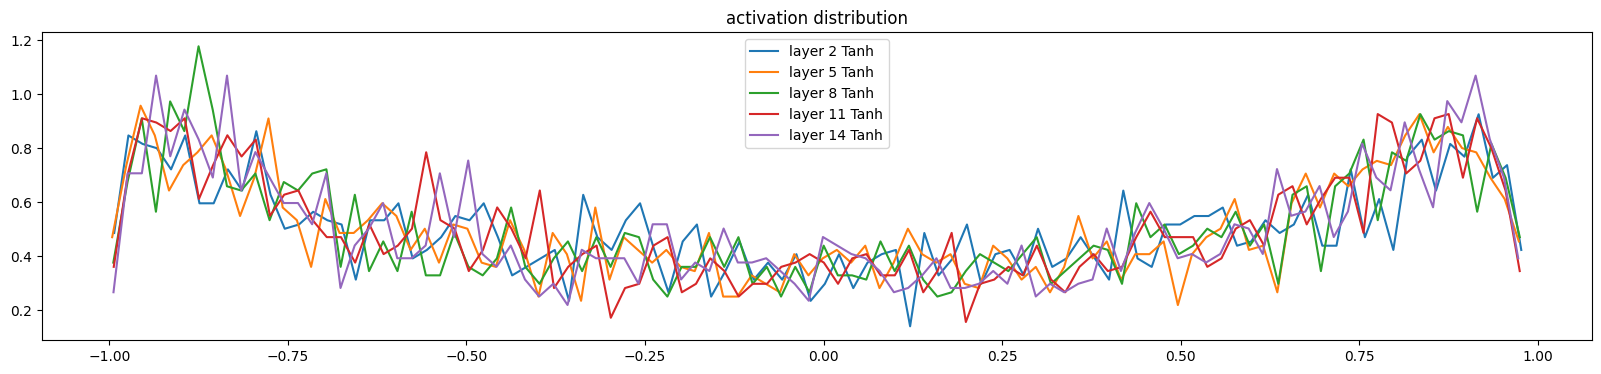

In [20]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f , std %.2f, saturated %.2f%%' % (i,layer.__class__.__name__,t.mean(),t.std(), (t.abs()>0.97).float().mean()*100))
        hy,hx = torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} {layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')


layer 2 (      Tanh): mean -0.00 , std 0.00, saturated 0.00%
layer 5 (      Tanh): mean +0.00 , std 0.00, saturated 0.00%
layer 8 (      Tanh): mean -0.00 , std 0.00, saturated 0.00%
layer 11 (      Tanh): mean -0.00 , std 0.00, saturated 0.00%
layer 14 (      Tanh): mean -0.00 , std 0.00, saturated 0.00%


Text(0.5, 1.0, 'gradient  distribution')

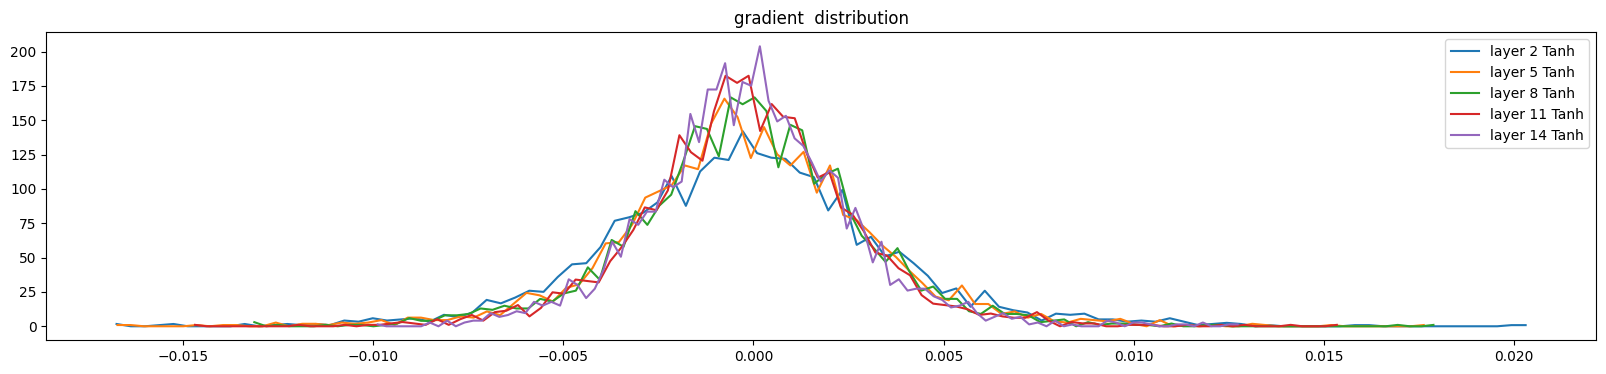

In [21]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f , std %.2f, saturated %.2f%%' % (i,layer.__class__.__name__,t.mean(),t.std(), (t.abs()>0.97).float().mean()*100))
        hy,hx = torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} {layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient  distribution')


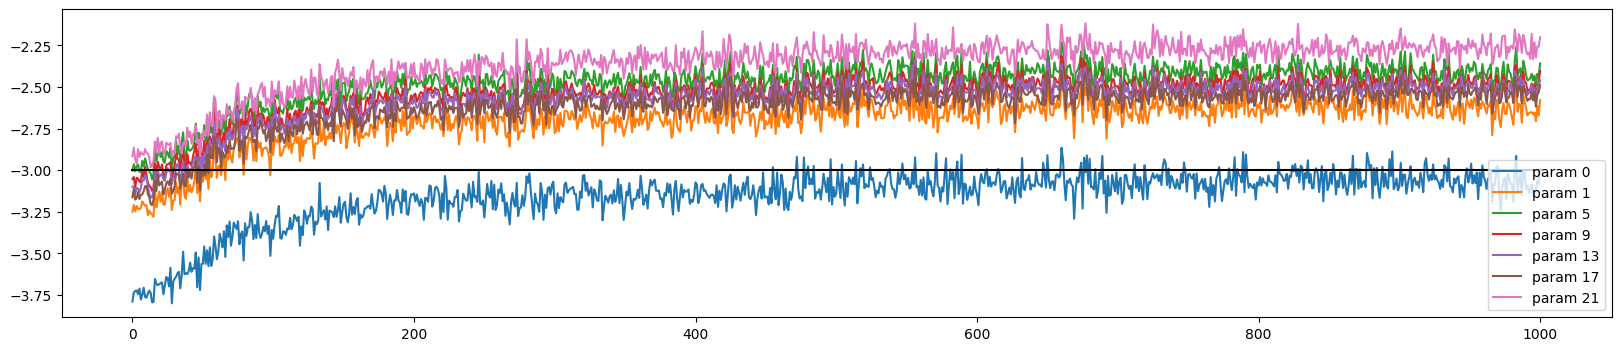

In [22]:
plt.figure(figsize=(20,4))
legends = []
for i , p in enumerate(params):
    if p.ndim ==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0,len(ud)],[-3,-3],'k')
plt.legend(legends)